# Human Activity Recognition using Support Vector Machines


# Binary Classification (Active vs. Inactive)


In [51]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold
import urllib.request
import zipfile
import os
import time

# Set random seed for reproducibility
np.random.seed(42)

# Download the dataset if it doesn't exist
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
dataset_path = "UCI HAR Dataset.zip"


In [52]:
# Set random seed for reproducibility
np.random.seed(42)

# Define dataset paths
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
dataset_path = "UCI HAR Dataset.zip"
dataset_dir = "UCI HAR Dataset"

# Check if the dataset directory exists
if not os.path.exists(dataset_dir):
    # Check if the zip file exists; download if not
    if not os.path.exists(dataset_path):
        print("Downloading the dataset...")
        urllib.request.urlretrieve(dataset_url, dataset_path)
        print("Download completed.")
    
    # Extract the dataset
    print("Extracting the dataset...")
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Extraction completed.")
else:
    print("Dataset directory already exists.")

# Rest of your code to load data...

Dataset directory already exists.


In [53]:
if not os.path.exists(dataset_path):
    print("Downloading the dataset...")
    urllib.request.urlretrieve(dataset_url, dataset_path)
    
    # Extracting the dataset
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Dataset downloaded and extracted.")
else:
    print("Dataset already exists.")

# Path to the extracted dataset
dataset_dir = "UCI HAR Dataset"


Dataset already exists.


##### Load and preprocess the HAR data

In [54]:
# Loading training data
X_train = pd.read_csv(os.path.join(dataset_dir, 'train/X_train.txt'), delim_whitespace=True, header=None)
y_train = pd.read_csv(os.path.join(dataset_dir, 'train/y_train.txt'), delim_whitespace=True, header=None)
subject_train = pd.read_csv(os.path.join(dataset_dir, 'train/subject_train.txt'), delim_whitespace=True, header=None)

# Loading test data
X_test = pd.read_csv(os.path.join(dataset_dir, 'test/X_test.txt'), delim_whitespace=True, header=None)
y_test = pd.read_csv(os.path.join(dataset_dir, 'test/y_test.txt'), delim_whitespace=True, header=None)
subject_test = pd.read_csv(os.path.join(dataset_dir, 'test/subject_test.txt'), delim_whitespace=True, header=None)

# Loading feature names
features = pd.read_csv(os.path.join(dataset_dir, 'features.txt'), delim_whitespace=True, header=None)
feature_names = features[1].values

# Loading activity labels
activity_labels = pd.read_csv(os.path.join(dataset_dir, 'activity_labels.txt'), delim_whitespace=True, header=None)
activity_dict = dict(zip(activity_labels[0], activity_labels[1]))


In [55]:
# Renaming columns
X_train.columns = feature_names
X_test.columns = feature_names
y_train.columns = ['activity']
y_test.columns = ['activity']
subject_train.columns = ['subject']
subject_test.columns = ['subject']

# Merge training and testing data
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
subjects = pd.concat([subject_train, subject_test])

# Map activity labels to activity names
y['activity_name'] = y['activity'].map(activity_dict)

# Print dataset information
print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Activity distribution:")
print(y['activity_name'].value_counts())

Dataset shape: (10299, 561)
Number of features: 561
Number of samples: 10299
Activity distribution:
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: activity_name, dtype: int64


#### Convert the original 6-class labels into a binary (active vs. inactive) 


Binary class distribution:
Inactive    5627
Active      4672
Name: binary_activity, dtype: int64
binary_activity  activity_name     
Active           WALKING               1722
                 WALKING_UPSTAIRS      1544
                 WALKING_DOWNSTAIRS    1406
Inactive         LAYING                1944
                 STANDING              1906
                 SITTING               1777
Name: activity_name, dtype: int64


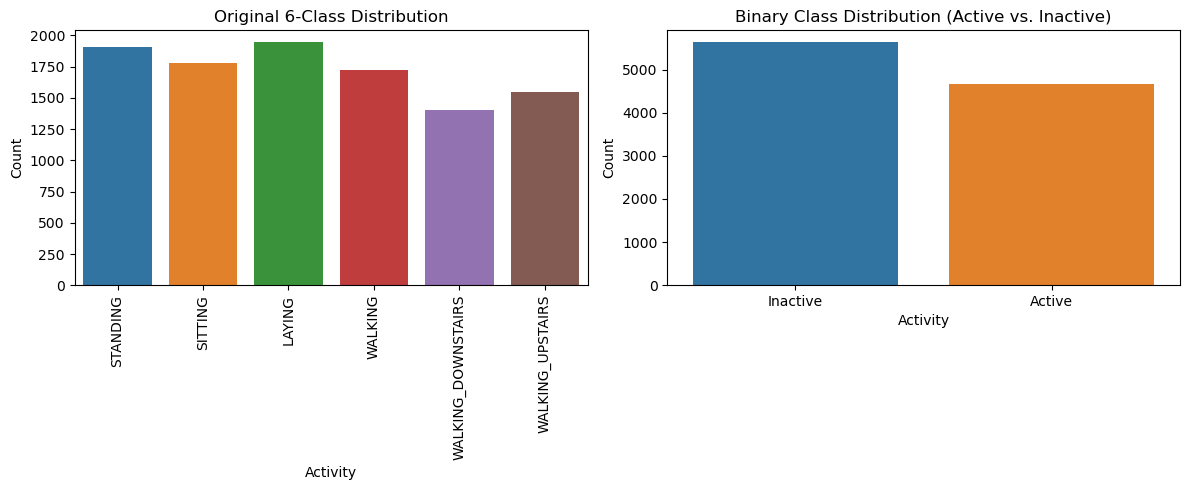

In [56]:
# Defining active activities: WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS (labels 1, 2, 3)
# Defining inactive activities: SITTING, STANDING, LAYING (labels 4, 5, 6)

y['binary_label'] = y['activity'].apply(lambda x: 1 if x in [1, 2, 3] else 0)
y['binary_activity'] = y['binary_label'].map({1: 'Active', 0: 'Inactive'})

# Print binary class distribution
print("\nBinary class distribution:")
print(y['binary_activity'].value_counts())
print(y.groupby('binary_activity')['activity_name'].value_counts())

# Visualization of class distribution
plt.figure(figsize=(12, 5))

# Original 6-class distribution
plt.subplot(1, 2, 1)
sns.countplot(data=y, x='activity_name')
plt.title('Original 6-Class Distribution')
plt.xticks(rotation=90)
plt.xlabel('Activity')
plt.ylabel('Count')

# Binary class distribution
plt.subplot(1, 2, 2)
sns.countplot(data=y, x='binary_activity')
plt.title('Binary Class Distribution (Active vs. Inactive)')
plt.xlabel('Activity')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('activity_distribution.png')
plt.show()

#### Train baseline SVM models with different kernels (linear, polynomial, RBF)

In [57]:
# Splitting the data back into training and testing sets
# We'll use the original train/test split for consistency
X_train = X.iloc[:len(X_train)]
X_test = X.iloc[len(X_train):]
y_train_binary = y['binary_label'].iloc[:len(y_train)].values
y_test_binary = y['binary_label'].iloc[len(y_train):].values
subject_train_vals = subjects['subject'].iloc[:len(subject_train)].values
subject_test_vals = subjects['subject'].iloc[len(subject_train):].values

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training subjects: {np.unique(subject_train_vals)}")
print(f"Testing subjects: {np.unique(subject_test_vals)}")


Training set shape: (7352, 561)
Testing set shape: (2947, 561)
Training subjects: [ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
Testing subjects: [ 2  4  9 10 12 13 18 20 24]


In [58]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to evaluate and print model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Prediction time: {predict_time:.2f} seconds")
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Inactive', 'Active'], 
                yticklabels=['Inactive', 'Active'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_").lower()}.png')
    plt.close()
    
    return model, accuracy, f1, precision, recall, train_time, predict_time

In [59]:
# Training and evaluate baseline SVM models with different kernels
print("\nTraining baseline SVM models...")
# Linear kernel
linear_svm = SVC(kernel='linear', random_state=42)
linear_model, linear_acc, linear_f1, linear_prec, linear_rec, linear_train_time, linear_pred_time = evaluate_model(
    linear_svm, X_train_scaled, X_test_scaled, y_train_binary, y_test_binary, "Linear SVM")

# Polynomial kernel
poly_svm = SVC(kernel='poly', degree=3, random_state=42)
poly_model, poly_acc, poly_f1, poly_prec, poly_rec, poly_train_time, poly_pred_time = evaluate_model(
    poly_svm, X_train_scaled, X_test_scaled, y_train_binary, y_test_binary, "Polynomial SVM")

# RBF kernel
rbf_svm = SVC(kernel='rbf', random_state=42)
rbf_model, rbf_acc, rbf_f1, rbf_prec, rbf_rec, rbf_train_time, rbf_pred_time = evaluate_model(
    rbf_svm, X_train_scaled, X_test_scaled, y_train_binary, y_test_binary, "RBF SVM")

# Comparing baseline models
baseline_results = pd.DataFrame({
    'Model': ['Linear SVM', 'Polynomial SVM', 'RBF SVM'],
    'Accuracy': [linear_acc, poly_acc, rbf_acc],
    'F1 Score': [linear_f1, poly_f1, rbf_f1],
    'Precision': [linear_prec, poly_prec, rbf_prec],
    'Recall': [linear_rec, poly_rec, rbf_rec],
    'Training Time (s)': [linear_train_time, poly_train_time, rbf_train_time],
    'Prediction Time (s)': [linear_pred_time, poly_pred_time, rbf_pred_time]
})

print("\nBaseline Model Comparison:")
print(baseline_results)



Training baseline SVM models...

Linear SVM Results:
Accuracy: 1.0000
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000
Training time: 0.27 seconds
Prediction time: 0.06 seconds

Polynomial SVM Results:
Accuracy: 0.9983
F1 Score: 0.9982
Precision: 0.9964
Recall: 1.0000
Training time: 0.35 seconds
Prediction time: 0.11 seconds

RBF SVM Results:
Accuracy: 0.9997
F1 Score: 0.9996
Precision: 0.9993
Recall: 1.0000
Training time: 0.32 seconds
Prediction time: 0.19 seconds

Baseline Model Comparison:
            Model  Accuracy  F1 Score  Precision  Recall  Training Time (s)  \
0      Linear SVM  1.000000  1.000000   1.000000     1.0           0.273985   
1  Polynomial SVM  0.998303  0.998201   0.996408     1.0           0.351886   
2         RBF SVM  0.999661  0.999640   0.999280     1.0           0.319873   

   Prediction Time (s)  
0             0.058583  
1             0.113946  
2             0.190248  


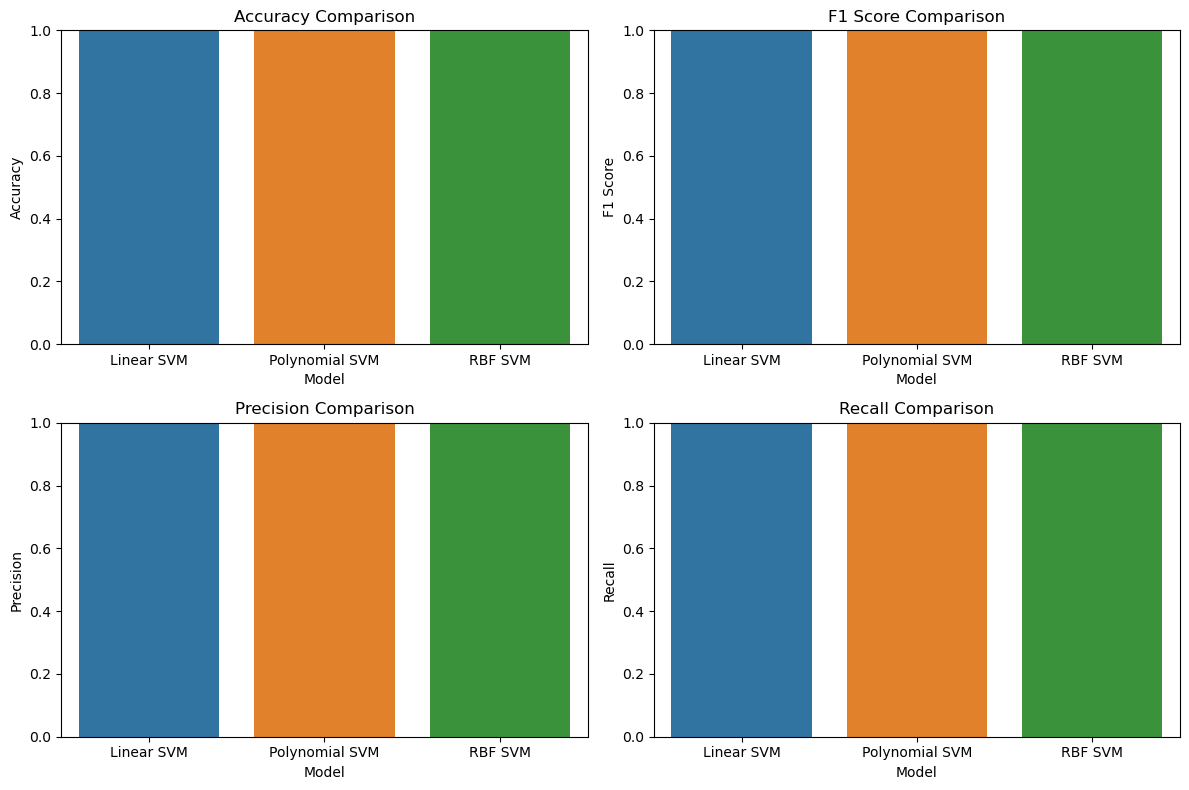

In [60]:
# Visualize baseline model comparison
plt.figure(figsize=(12, 8))

metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Model', y=metric, data=baseline_results)
    plt.title(f'{metric} Comparison')
    plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('baseline_model_comparison.png')
plt.show()

##### Dimension Reduction with PCA


Applying PCA for dimension reduction...


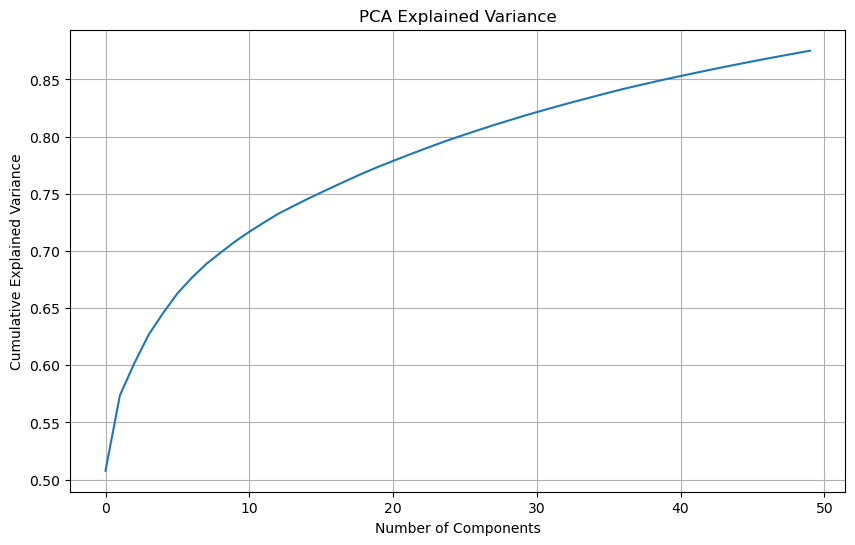

In [61]:
print("\nApplying PCA for dimension reduction...")

# Create a pipeline with PCA and SVM
pca = PCA(n_components=50)  # Start with 50 components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Visualize explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.title('PCA Explained Variance')
plt.savefig('pca_explained_variance.png')
plt.show()

In [62]:
# Find number of components needed to explain 80% variance
n_components_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.80) + 1
print(f"Number of components needed to explain 80% variance: {n_components_95}")

Number of components needed to explain 80% variance: 26


We used 80% because 95% was including too many features

In [63]:
# Refit PCA with the optimal number of components
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Reduced feature dimension from {X_train_scaled.shape[1]} to {X_train_pca.shape[1]}")

Reduced feature dimension from 561 to 26


In [65]:
# Evaluate models with PCA-reduced features
print("\nTraining SVM models with PCA-reduced features...")

# Linear kernel with PCA
linear_svm_pca = SVC(kernel='linear', random_state=42)
linear_model_pca, linear_acc_pca, linear_f1_pca, linear_prec_pca, linear_rec_pca, linear_train_time_pca, linear_pred_time_pca = evaluate_model(
    linear_svm_pca, X_train_pca, X_test_pca, y_train_binary, y_test_binary, "Linear SVM with PCA")

# RBF kernel with PCA
rbf_svm_pca = SVC(kernel='rbf', random_state=42)
rbf_model_pca, rbf_acc_pca, rbf_f1_pca, rbf_prec_pca, rbf_rec_pca, rbf_train_time_pca, rbf_pred_time_pca = evaluate_model(
    rbf_svm_pca, X_train_pca, X_test_pca, y_train_binary, y_test_binary, "RBF SVM with PCA")

# Polynomial kernel
poly_svm_pca = SVC(kernel='poly', degree=3, random_state=42)
poly_model_pca, poly_acc_pca, poly_f1_pca, poly_prec_pca, poly_rec_pca, poly_train_time_pca, poly_pred_time_pca = evaluate_model(
    poly_svm_pca, X_train_pca, X_test_pca, y_train_binary, y_test_binary, "Polynomial SVM with PCA")



Training SVM models with PCA-reduced features...

Linear SVM with PCA Results:
Accuracy: 0.9997
F1 Score: 0.9996
Precision: 0.9993
Recall: 1.0000
Training time: 0.05 seconds
Prediction time: 0.00 seconds

RBF SVM with PCA Results:
Accuracy: 0.9997
F1 Score: 0.9996
Precision: 0.9993
Recall: 1.0000
Training time: 0.08 seconds
Prediction time: 0.04 seconds

Polynomial SVM with PCA Results:
Accuracy: 0.9983
F1 Score: 0.9982
Precision: 0.9964
Recall: 1.0000
Training time: 0.08 seconds
Prediction time: 0.02 seconds


##### Hyperparameter Tuning using GridSearchCV


In [45]:
print("\nPerforming hyperparameter tuning...")

# Use PCA-reduced features for grid search to save computation time
# Define parameter grid for RBF kernel 
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'class_weight': [None, 'balanced']
}

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=SVC(kernel='rbf', random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train_pca, y_train_binary)

# Get best parameters and score
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score (F1): {grid_search.best_score_:.4f}")


Performing hyperparameter tuning...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best parameters: {'C': 1, 'class_weight': None, 'gamma': 'scale'}
Best cross-validation score (F1): 0.9994


In [46]:
# Evaluate best model on test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_pca)

accuracy_best = accuracy_score(y_test_binary, y_pred_best)
f1_best = f1_score(y_test_binary, y_pred_best)
precision_best = precision_score(y_test_binary, y_pred_best)
recall_best = recall_score(y_test_binary, y_pred_best)

print("\nBest Model Results:")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"F1 Score: {f1_best:.4f}")
print(f"Precision: {precision_best:.4f}")
print(f"Recall: {recall_best:.4f}")


Best Model Results:
Accuracy: 0.9997
F1 Score: 0.9996
Precision: 0.9993
Recall: 1.0000


#### Evaluate and interpret results using confusion matrices and classification metrics

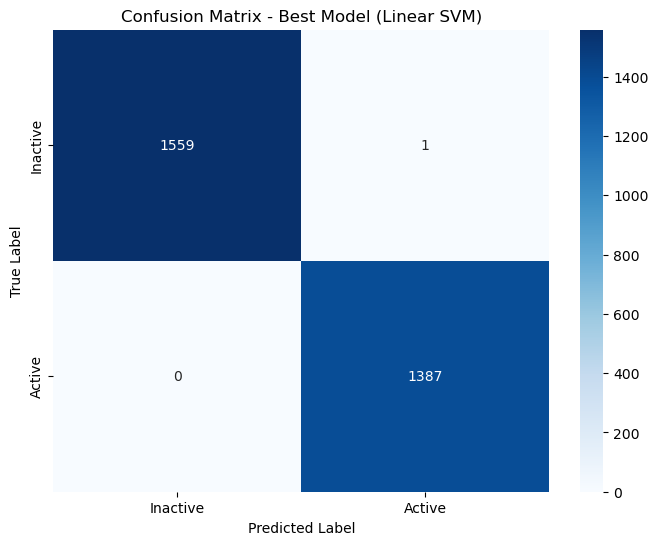


Classification Report:
              precision    recall  f1-score   support

    Inactive       1.00      1.00      1.00      1560
      Active       1.00      1.00      1.00      1387

    accuracy                           1.00      2947
   macro avg       1.00      1.00      1.00      2947
weighted avg       1.00      1.00      1.00      2947


Demonstrating subject-wise split...
Total unique subjects: 30


In [47]:
# Confusion matrix for best model
cm_best = confusion_matrix(y_test_binary, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Inactive', 'Active'], 
            yticklabels=['Inactive', 'Active'])
plt.title('Confusion Matrix - Best Model (Linear SVM)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_best_model.png')
plt.show()

# Complete classification report
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_best, target_names=['Inactive', 'Active']))

# Step 6: Subject-wise Split (for demonstration, not retraining)
print("\nDemonstrating subject-wise split...")

# Identify unique subjects
unique_subjects = np.unique(subjects['subject'])
print(f"Total unique subjects: {len(unique_subjects)}")


In [48]:
# Creating group k-fold for subject-wise cross-validation
group_kfold = GroupKFold(n_splits=5)

# Example of what a subject-wise split would look like
for i, (train_idx, test_idx) in enumerate(group_kfold.split(X, y['binary_label'], subjects['subject'])):
    train_subjects = subjects['subject'].iloc[train_idx].unique()
    test_subjects = subjects['subject'].iloc[test_idx].unique()
    
    print(f"\nFold {i+1}:")
    print(f"  Training subjects: {sorted(train_subjects)}")
    print(f"  Testing subjects: {sorted(test_subjects)}")
    
    # Check for overlap (should be none)
    overlap = set(train_subjects) & set(test_subjects)
    print(f"  Subject overlap: {overlap}")
    
    # Show the first fold as an example
    if i == 0:
        break

# Comparing all models' performance
all_models = pd.DataFrame({
    'Model': ['Linear SVM', 'Polynomial SVM', 'RBF SVM', 
              'Linear SVM with PCA', 'RBF SVM with PCA', 'Tuned RBF SVM with PCA'],
    'Accuracy': [linear_acc, poly_acc, rbf_acc, 
                linear_acc_pca, rbf_acc_pca, accuracy_best],
    'F1 Score': [linear_f1, poly_f1, rbf_f1, 
                linear_f1_pca, rbf_f1_pca, f1_best],
    'Precision': [linear_prec, poly_prec, rbf_prec, 
                 linear_prec_pca, rbf_prec_pca, precision_best],
    'Recall': [linear_rec, poly_rec, rbf_rec, 
              linear_rec_pca, rbf_rec_pca, recall_best]
})

print("\nAll Models Comparison:")
print(all_models)


Fold 1:
  Training subjects: [2, 3, 4, 6, 7, 8, 9, 10, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30]
  Testing subjects: [1, 5, 11, 13, 16, 25]
  Subject overlap: set()

All Models Comparison:
                    Model  Accuracy  F1 Score  Precision  Recall
0              Linear SVM  1.000000  1.000000   1.000000     1.0
1          Polynomial SVM  0.998303  0.998201   0.996408     1.0
2                 RBF SVM  0.999661  0.999640   0.999280     1.0
3     Linear SVM with PCA  0.999661  0.999640   0.999280     1.0
4        RBF SVM with PCA  0.999661  0.999640   0.999280     1.0
5  Tuned RBF SVM with PCA  0.999661  0.999640   0.999280     1.0


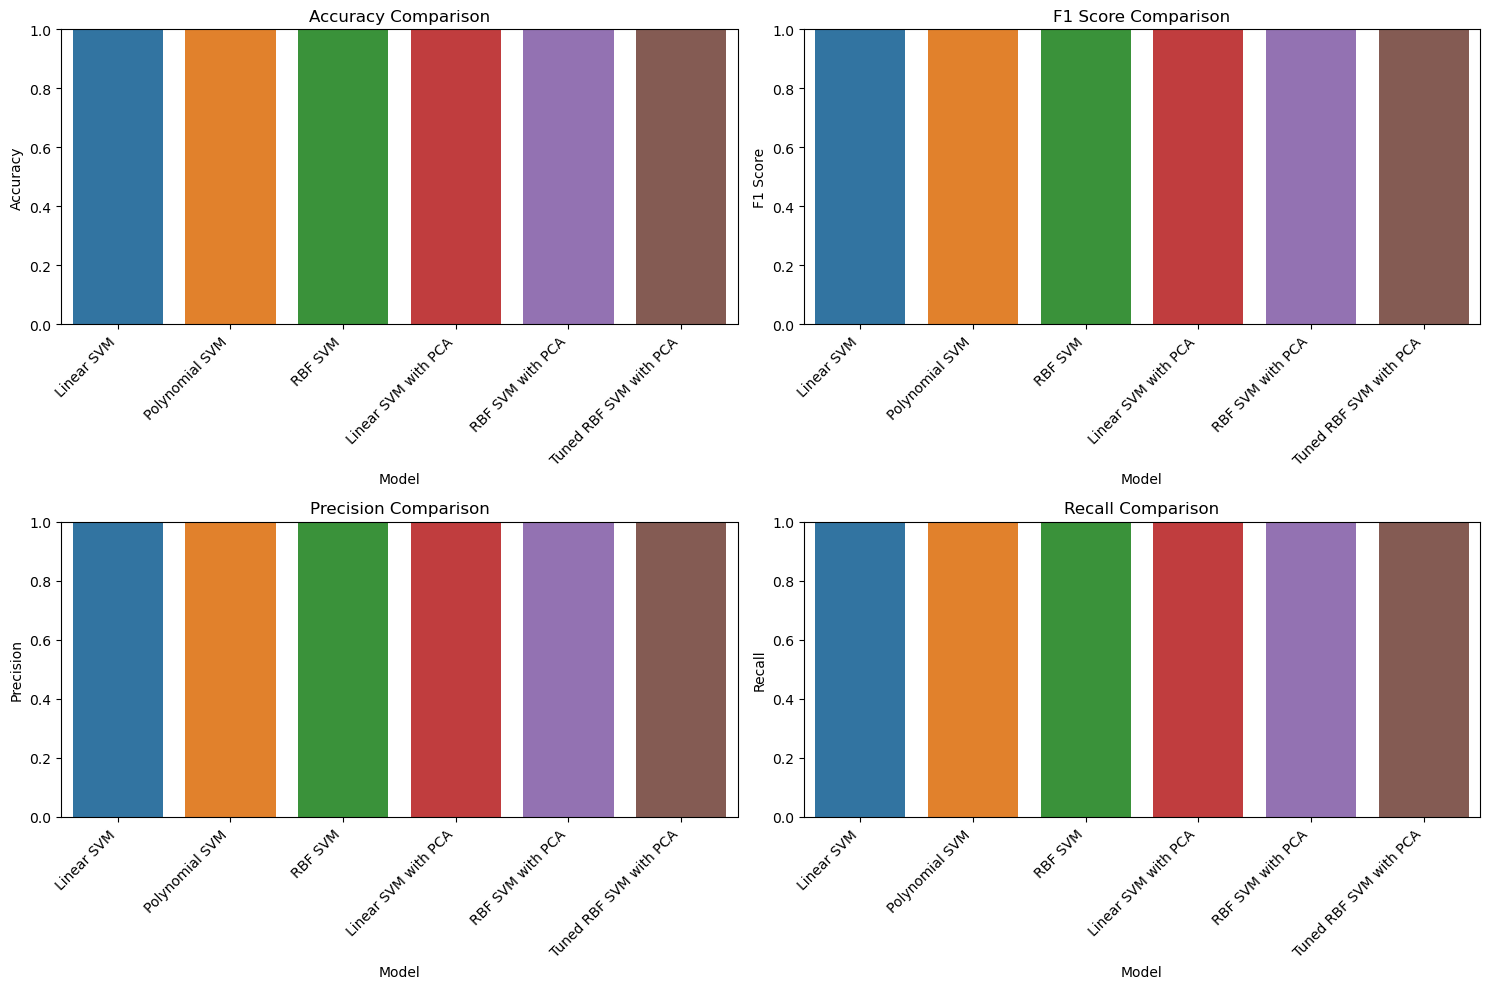

In [49]:
# Visualizing the final model comparison
plt.figure(figsize=(15, 10))

metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Model', y=metric, data=all_models)
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('all_models_comparison.png')
plt.show()
